# Bounding box detection - Racoon data


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

### Import the necessary libraries

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [35]:
!pip install patool
import patoolib


In [9]:
import pandas as pd
import numpy as np
import cv2

### Change directory

In [34]:
import os
os.chdir('/content/drive/MyDrive/ACV')
os.getcwd()

'/content/drive/MyDrive/ACV'

### Load the training data from train.csv file

In [38]:

df = pd.read_csv('train_labels.csv')

### Print the shape of the train dataset

In [39]:
df.shape

(173, 8)

In [40]:
df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290
3,raccoon-63.jpg,600,400,raccoon,227,93,403,298
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127


### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [41]:
IMAGE_SIZE=128

### With the help of csv.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [44]:
import csv
with open('train_labels.csv','r') as csvfile:
  paths=[]
  coords=np.zeros((sum(1 for line in csvfile) -1, 4))
  spamreader=csv.reader(csvfile,delimiter=',')
  csvfile.seek(0)
  next(spamreader,None)
  for i,row in enumerate(spamreader):
    for j,r in enumerate(row):
      if((j !=0) & (j!= 3)):
        row[j] = int(r)

    path,width,height,class_,xmin,ymin,xmax,ymax=row
    paths.append(path)
    coords[i,0]=xmin * IMAGE_SIZE/width
    coords[i,1]=ymin * IMAGE_SIZE/height
    coords[i,2]=xmax * IMAGE_SIZE/width
    coords[i,3]=ymax * IMAGE_SIZE/height

### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [45]:
from tensorflow.keras.applications.mobilenet import MobileNet,preprocess_input

In [47]:
from PIL import Image
batch_images=np.zeros((len(paths),IMAGE_SIZE,IMAGE_SIZE,3),dtype=np.float32)

for i,f in enumerate(paths):
  img=Image.open('images/images/'+f)
  img=img.resize((IMAGE_SIZE,IMAGE_SIZE))
  img=img.convert('RGB')
  batch_images[i] = preprocess_input(np.array(img,dtype=np.float32))

In [48]:
batch_images

array([[[[-0.38823527, -0.20784312, -0.3098039 ],
         [-0.8901961 , -0.7647059 , -0.84313726],
         [-0.9137255 , -0.8509804 , -0.8980392 ],
         ...,
         [ 0.04313731,  0.5137255 ,  0.05882359],
         [ 0.04313731,  0.4666667 ,  0.18431377],
         [ 0.26274514,  0.654902  ,  0.38823533]],

        [[-0.4352941 , -0.27843136, -0.36470586],
         [-0.9529412 , -0.8666667 , -0.92941177],
         [-0.8509804 , -0.79607844, -0.827451  ],
         ...,
         [-0.23921567,  0.21568632, -0.23921567],
         [-0.0745098 ,  0.33333337,  0.00392163],
         [ 0.09019613,  0.4431373 ,  0.20784318]],

        [[-0.7019608 , -0.5764706 , -0.64705884],
         [-0.85882354, -0.77254903, -0.8117647 ],
         [-0.81960785, -0.78039217, -0.78039217],
         ...,
         [-0.2862745 ,  0.1686275 , -0.5058824 ],
         [-0.1607843 ,  0.26274514, -0.31764704],
         [-0.08235294,  0.254902  , -0.02745098]],

        ...,

        [[-0.04313725,  0.27843142, -0

In [50]:
import tensorflow as tf

from tensorflow.keras import Model
from tensorflow.keras.applications.mobilenet import MobileNet,preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau,Callback
from tensorflow.keras.layers import Conv2D,Reshape
from tensorflow.keras.utils import Sequence
from tensorflow.keras.backend import epsilon

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [51]:
ALPHA=0.5

model=MobileNet(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3),include_top=False,alpha=ALPHA)
for layer in model.layers:
  layer.trainable=False

x=model.layers[-1].output
x=Conv2D(4,kernel_size=4,name="coords")(x)
x=Reshape((4,))(x)

model=Model(inputs=model.input,outputs=x)


5578752/5577668 [==============================] - 0s 0us/step


### Define a custom loss function IoU which calculates Intersection Over Union

In [53]:
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.compat.v1.py_func(loss, [y_true, y_pred], tf.float32)
    return iou

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [54]:
model.compile(optimizer='adam',loss='mse',metrics=IoU)
model.fit(batch_images,coords,batch_size=32,epochs=30,verbose=1) 

Epoch 1/30
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
6/6 [==============================] - 1s 127ms/step - loss: 4740.8311 - IoU: 0.0460
Epoch 2/30
6/6 [==============================] - 1s 127ms/step - loss: 1932.0587 - IoU: 0.2087
Epoch 3/30
6/6 [==============================] - 1s 127ms/step - loss: 607.7672 - IoU: 0.4524
Epoch 4/30
6/6 [========================

### Pick a test image from the given data

In [130]:
test_img=Image.open('images/raccoon-1.jpg')

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [83]:
test_img =  test_img.resize((IMAGE_SIZE,IMAGE_SIZE))

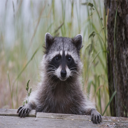

In [63]:
test_img

In [133]:
test_img=cv2.imread('images/raccoon-1.jpg')


In [135]:
image_height,image_width,_=img_resize.shape

In [134]:
img_resize=cv2.resize(test_img,(IMAGE_SIZE,IMAGE_SIZE),interpolation=cv2.INTER_AREA)
img_resize=cv2.cvtColor(img_resize,cv2.COLOR_BGR2RGB)

In [121]:
test_img=preprocess_input(np.array(test_img,dtype=np.float32))

In [136]:
img_resize.shape

(128, 128, 3)

In [137]:
test_img=img_resize.reshape(1,128,128,3)

In [138]:
test_img.shape

(1, 128, 128, 3)

### Predict the coordinates of the bounding box for the given test image

In [139]:
region=model.predict(test_img)

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

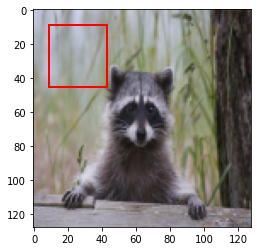

In [141]:
x0 = int(region[0][1] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[0][1] * image_height / IMAGE_SIZE)

x1 = int((region[0][2]) * image_width / IMAGE_SIZE)
y1 = int((region[0][3]) * image_height / IMAGE_SIZE)


import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np


# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(img_resize)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()